Ajustes feitos na versão inicial(completa):
    Retirar parágrafos que não impactaram positivamente na busca: nota_escopo (piora os resultados) e tem_especializacao e tem_generalizacao (não ajudam e podem atrapalhar)
    Aumentar ocorrência do termo principal (O Termo é xxx. Xxxx tem os seguintes sinônimos. XXX tem ....)

Salvar dataframes em disco para, em próximas cargas, não trazer dados atualizados que impactam as métricas de comparação.

Criar bases com nome: vce_relevancia_xxxx

# Imports 

In [1]:
from collections import Counter

In [2]:
import pandas as pd

In [3]:
import re

In [4]:
import numpy as np


In [5]:
from tqdm import tqdm

In [6]:
import os

In [7]:
import csv

In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import json

In [9]:
%%time
from haystack.document_stores import ElasticsearchDocumentStore

OpenAI tiktoken module is not available for Python < 3.8,Linux ARM64 and AARCH64. Falling back to GPT2TokenizerFast.


CPU times: user 4.02 s, sys: 705 ms, total: 4.73 s
Wall time: 19.9 s


In [10]:
from haystack.nodes import EmbeddingRetriever

import logging
logging.getLogger("haystack").setLevel(logging.WARNING) #WARNING, INFO

In [11]:
# Para ter repetibilidade nos resultados
random_state = 1

# Tratar valores infinitos (+ e -) como np.NaN
pd.options.mode.use_inf_as_na = True

# IMPORTANTE para tornar figuras interativas
# %matplotlib notebook

# Tamanho padrão das figuras
figsize=(10,6)

pd.set_option('display.max_row', 1000)

pd.set_option('display.max_columns', 50)

pd.set_option('display.column_space', 40)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 200)


In [19]:
PATH_QUERY = '../data/index_juris_vce/query.csv'
PATH_QREL =  '../data/index_juris_vce/qrel.csv'
PATH_DOC =  '../data/index_juris_vce/doc.csv'

In [13]:
import re

# Data Exploration - Jurisprudência (query) 

In [66]:
df_enunciado = pd.read_csv(PATH_QUERY)

In [67]:
df_enunciado.shape

(16022, 11)

In [68]:
df_enunciado.head()

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
0,34899,"A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perd...","Lei Ordinária 8.443/1992, art. 58, inciso II",NaN,Responsabilidade,775,REPRESENTAÇÃO,Acórdão 2669/2012 - Plenário,2012-10-03,RELATOR,JOSÉ JORGE
1,30271,"A contratação de médicos e profissionais da área de saúde, como colaboradores eventuais, com pag...",NaN,NaN,Pessoal,1131,REPRESENTAÇÃO,Acórdão 2669/2012 - Plenário,2012-10-03,RELATOR,JOSÉ JORGE
2,26574,"Para que seja conhecido o recurso de revisão, não basta apenas que se apresente documento ainda ...",NaN,NaN,Direito processual,5288,TOMADA DE CONTAS,Acórdão 514/2013 - Plenário,2013-03-13,RELATOR,ANA ARRAES
3,17902,"A contratação de serviços comuns de engenharia que possam ser objetivamente definidos em edital,...",NaN,NaN,Licitação,932,RELATÓRIO DE LEVANTAMENTO,Acórdão 3144/2012 - Plenário,2012-11-21,RELATOR,ANA ARRAES
4,26089,"A Fundação Banco do Brasil, por receber recursos da União, deve observar, quando do repasse de r...",NaN,NaN,Competência do TCU,5095,TOMADA DE CONTAS ESPECIAL,Acórdão 2071/2013 - Plenário,2013-08-07,RELATOR,JOSÉ JORGE


In [34]:
list_property = ['PARADIGMATIC', 'AREA_NAME', 'NORMATIVE_PROCESS_TYPE',  'NORMATIVE_AUTHOR_TYPE',  'NORMATIVE_AUTHOR_NAME']

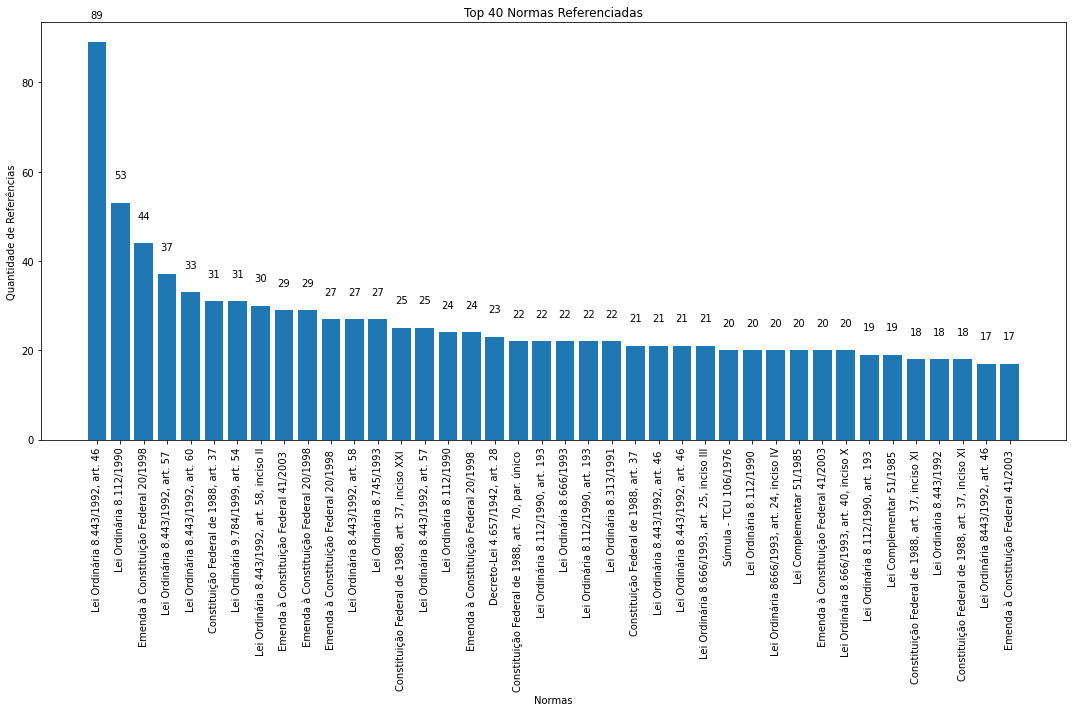

In [79]:
normas_referenciadas = df_enunciado['REFERENCE_LIST'].str.extractall(r'([^||]+)')[0]

# Calcular o total de ocorrências de cada norma referenciada
contagem_normas = Counter(normas_referenciadas)

# Obter as top 40 normas referenciadas mais frequentes
top_40_normas = contagem_normas.most_common(40)

# Extrair os nomes e as quantidades das top 40 normas
normas = [norma[0] for norma in top_40_normas]
quantidades = [norma[1] for norma in top_40_normas]

# Plotar o gráfico de barras
plt.figure(figsize=(15, 10))
plt.bar(normas, quantidades)
plt.title('Top 40 Normas Referenciadas')
plt.xlabel('Normas')
plt.ylabel('Quantidade de Referências')
plt.xticks(rotation=90)

# Adicionar rótulos com a quantidade de referências em cada barra
for i, v in enumerate(quantidades):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

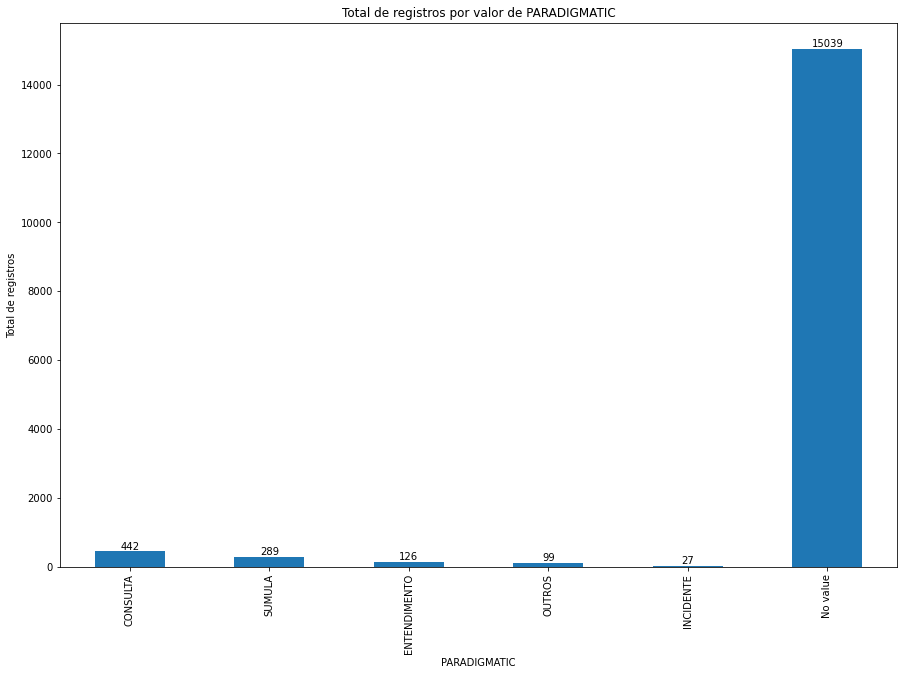

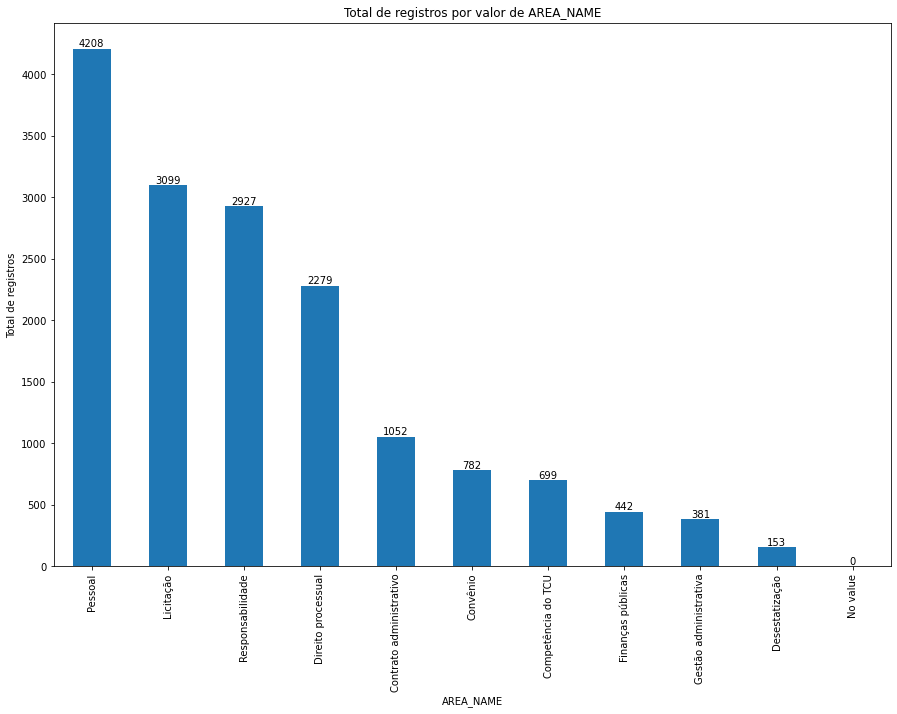

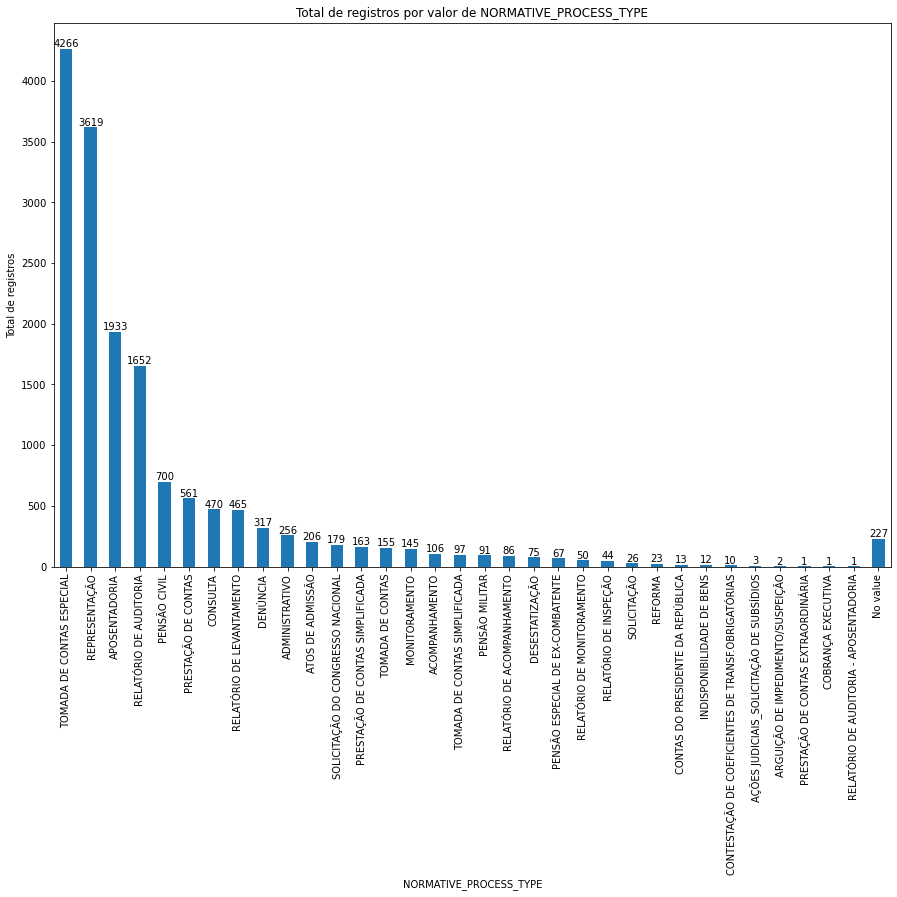

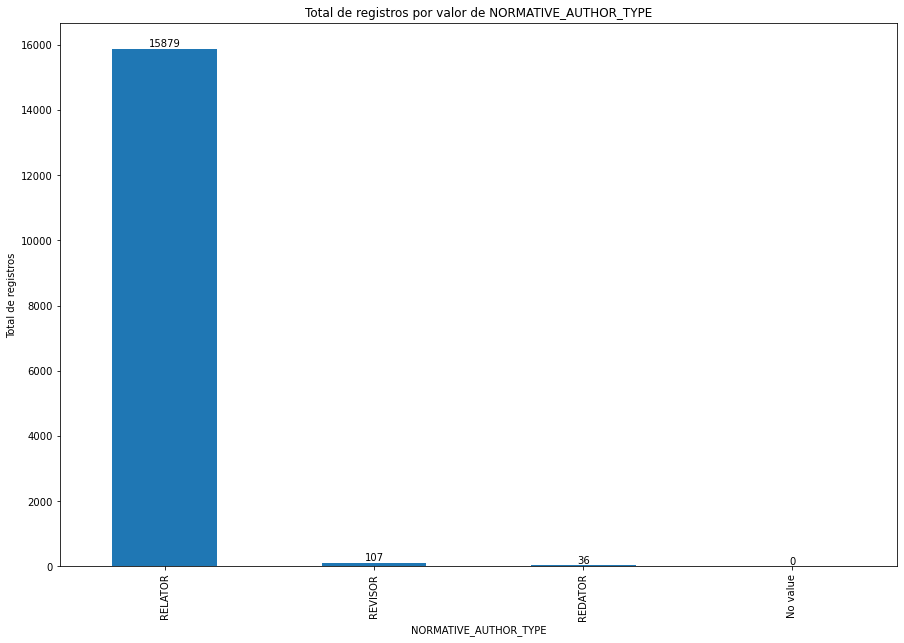

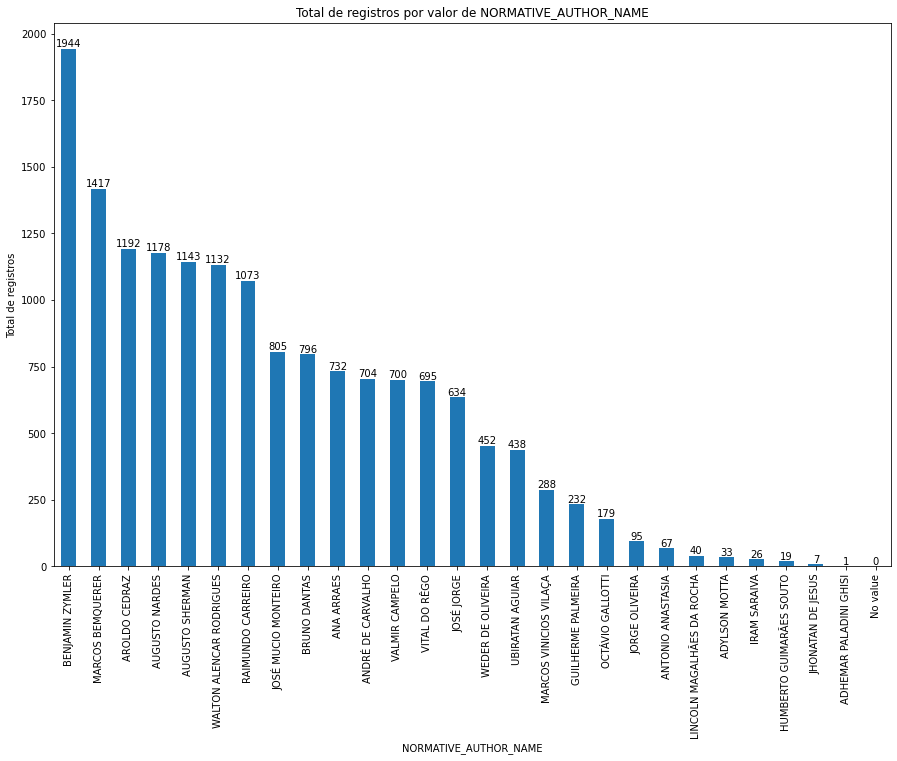

In [41]:
# Loop através das propriedades
for property_name in list_property:
    # Calcular o total de registros por valor da propriedade
    property_counts = df_enunciado[property_name].value_counts()

    # Obter o total de registros sem valor (sem registros)
    total_missing = df_enunciado[property_name].isna().sum()

    # Adicionar o total de registros sem valor no total de registros por valor
    property_counts['No value'] = total_missing

    # Plotar o gráfico de barras
    plt.figure(figsize=(15,10))
    property_counts.plot(kind='bar')
    plt.title(f'Total de registros por valor de {property_name}')
    plt.xlabel(property_name)
    plt.ylabel('Total de registros')

    # Adicionar rótulos com o total de registros em cada barra
    for i, v in enumerate(property_counts):
        plt.annotate(str(v), xy=(i, v), ha='center', va='bottom')

    plt.show()

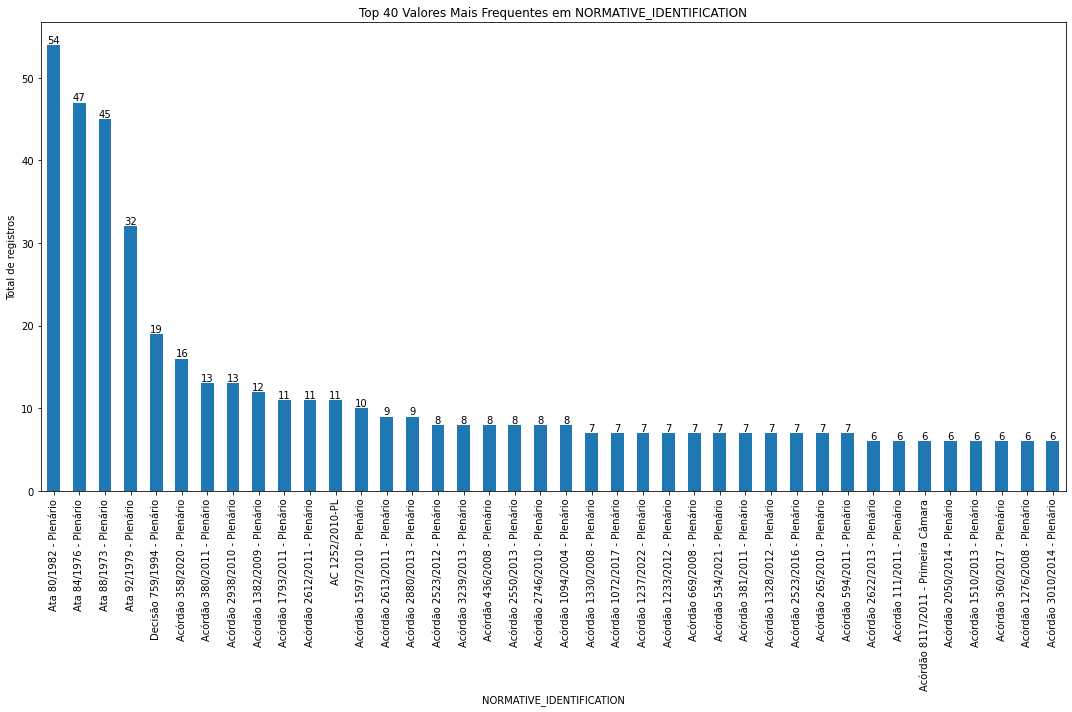

In [49]:
# Definir a coluna a ser explorada
column_name = 'NORMATIVE_IDENTIFICATION'

# Calcular o total de registros por valor na coluna
value_counts = df_enunciado[column_name].value_counts()

# Selecionar os top 40 valores mais frequentes
top_values = value_counts.head(40)

# Plotar o gráfico de barras
plt.figure(figsize=(15,10))
ax = top_values.plot(kind='bar')
plt.title(f'Top 40 Valores Mais Frequentes em {column_name}')
plt.xlabel(column_name)
plt.ylabel('Total de registros')
plt.xticks(rotation=90)
# Adicionar rótulos com o total de registros em cada barra
# Adicionar rótulos com a quantidade de registros em cada barra
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


plt.tight_layout()
plt.show()

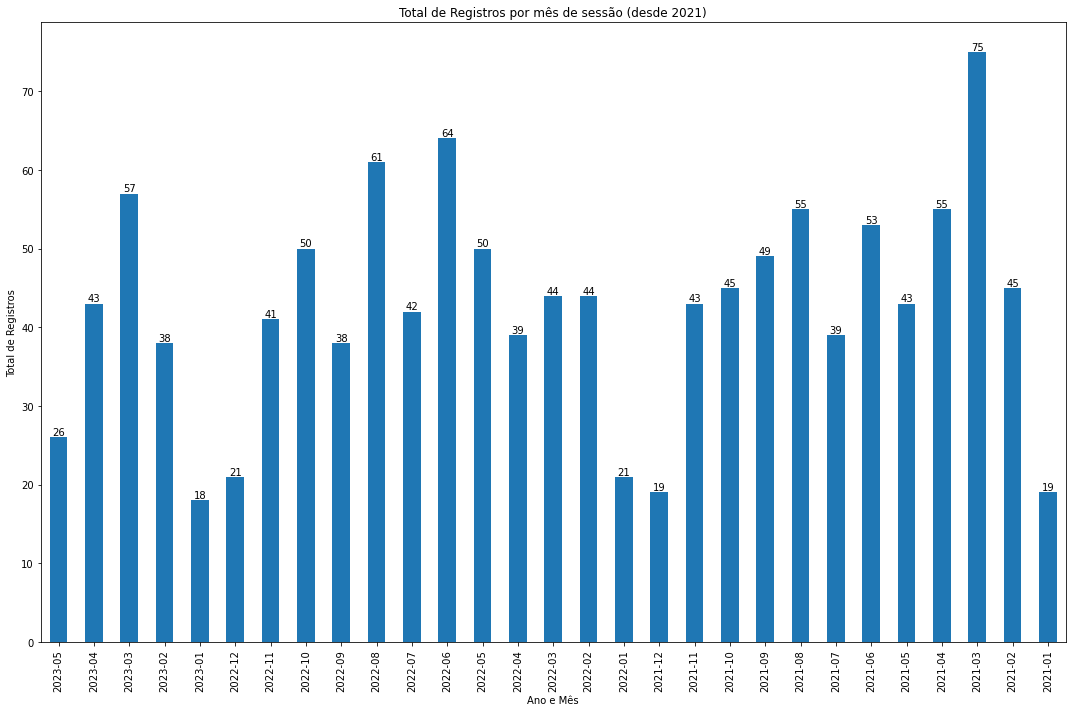

In [61]:
# Calcular o total de registros por ano e mês
df_enunciado['YearMonth'] = pd.to_datetime(df_enunciado[df_enunciado['NORMATIVE_DATE']>'2021']['NORMATIVE_DATE']).dt.to_period('M')
total_by_yearmonth = df_enunciado['YearMonth'].value_counts().sort_index(ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(15, 10))
ax = total_by_yearmonth.plot(kind='bar')
plt.title('Total de Registros por mês de sessão (desde 2021)')
plt.xlabel('Ano e Mês')
plt.ylabel('Total de Registros')
plt.xticks(rotation=90)

# Adicionar rótulos com a quantidade de registros em cada barra
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()

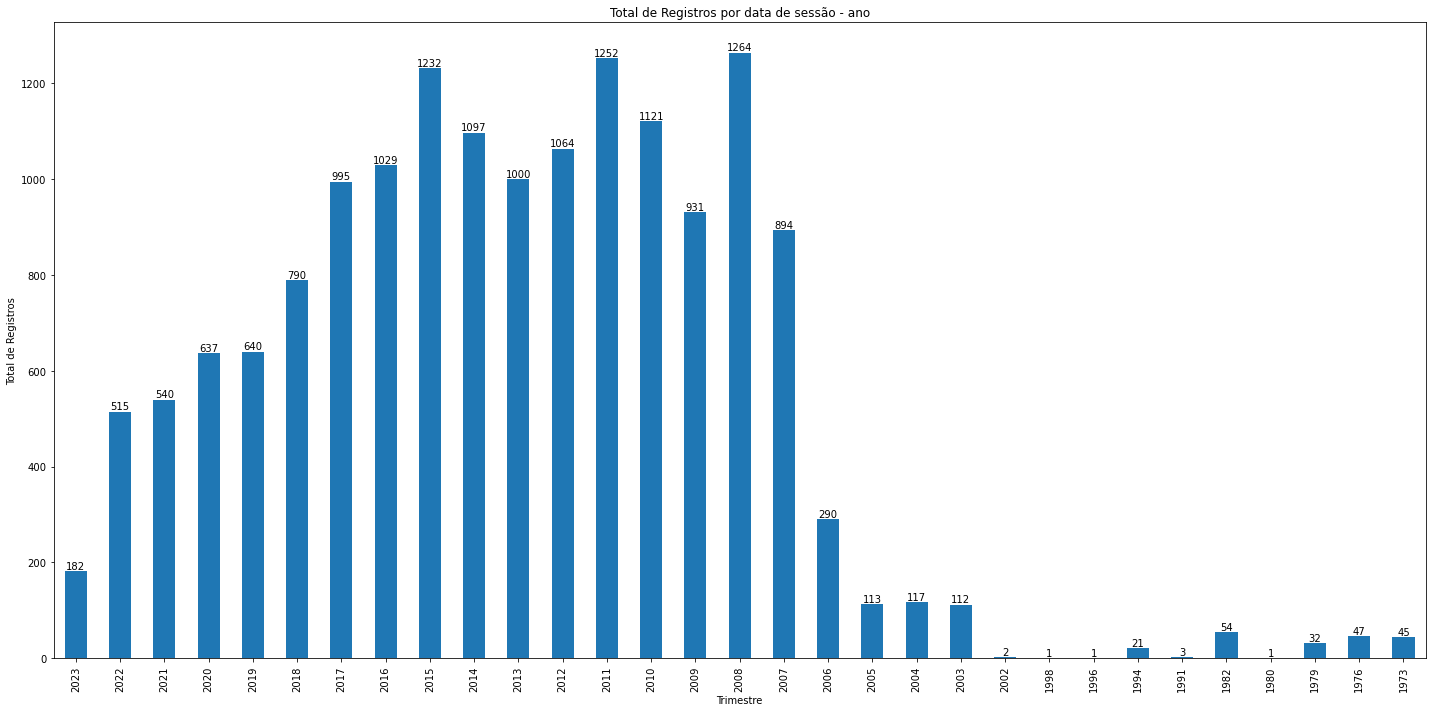

In [87]:

# Calcular o total de registros por trimestre
total_by_period = df_enunciado['NORMATIVE_DATE'].apply(lambda x: pd.Period(x, freq='Y')).value_counts().sort_index(ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(20, 10))
ax = total_by_period.plot(kind='bar')
plt.title('Total de Registros por data de sessão - ano')
plt.xlabel('Trimestre')
plt.ylabel('Total de Registros')
plt.xticks(rotation=90)
# Adicionar rótulos com a quantidade de registros em cada barra
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout()
del total_by_period
plt.show()

Total por data da sessão (trimestre)

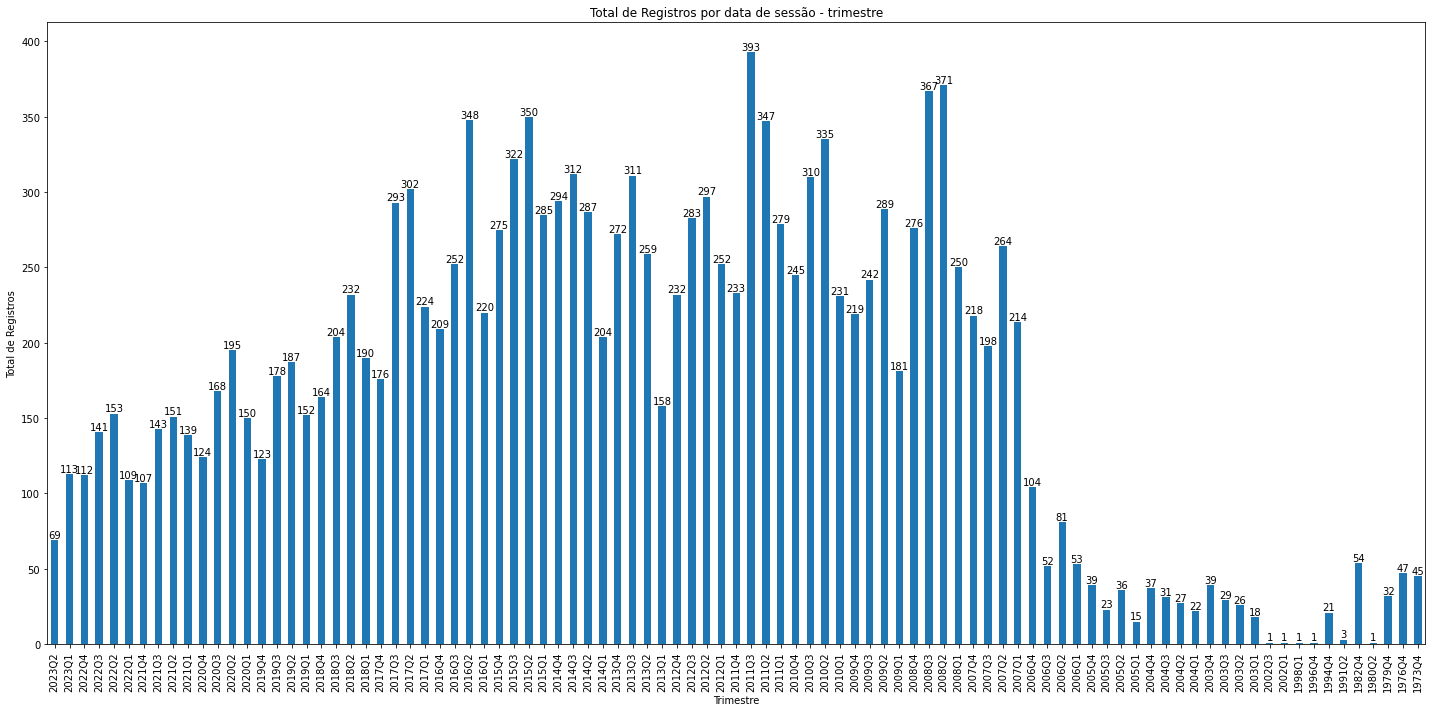

In [86]:

# Calcular o total de registros por trimestre
df_enunciado['YearQuarter'] = pd.to_datetime(df_enunciado['NORMATIVE_DATE']).dt.to_period('Q')
# total_by_period = df_enunciado['YearQuarter'].value_counts().sort_index(ascending=False)
# Calcular o total de registros por trimestre
total_by_period = df_enunciado['NORMATIVE_DATE'].apply(lambda x: pd.Period(x, freq='Q')).value_counts().sort_index(ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(20, 10))
ax = total_by_period.plot(kind='bar')
plt.title('Total de Registros por data de sessão - trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Total de Registros')
plt.xticks(rotation=90)
# Adicionar rótulos com a quantidade de registros em cada barra
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout()
del total_by_period
plt.show()

Tamanho dos enunciados - palavras, caracteres e tokens

In [88]:
df_enunciado['LEN_TEXT_CHAR'] = df_enunciado['TEXT'].apply(len)

In [90]:
df_enunciado['LEN_TEXT_CHAR_LOG'] = round(np.log(df_enunciado['TEXT'].apply(len))).astype(int)


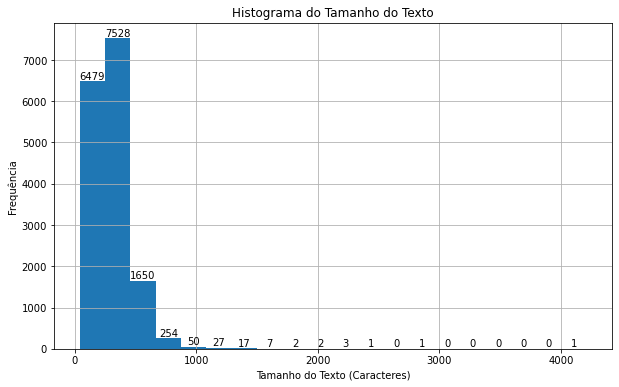

In [93]:

# Plotar o histograma
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_enunciado['LEN_TEXT_CHAR'], bins=20)
plt.title('Histograma do Tamanho do Texto')
plt.xlabel('Tamanho do Texto (Caracteres)')
plt.ylabel('Frequência')
plt.grid(True)

# Adicionar rótulos com a quantidade de registros em cada barra
for i, patch in enumerate(patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, int(height),
             ha='center', va='bottom')

plt.show()


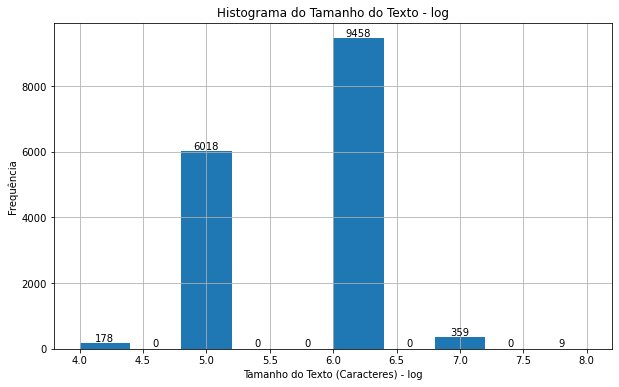

In [105]:

# Plotar o histograma
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_enunciado['LEN_TEXT_CHAR_LOG'], bins=10)
plt.title('Histograma do Tamanho do Texto - log')
plt.xlabel('Tamanho do Texto (Caracteres) - log')
plt.ylabel('Frequência')
plt.grid(True)

# Adicionar rótulos com a quantidade de registros em cada barra
for i, patch in enumerate(patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, int(height),
             ha='center', va='bottom')

plt.show()


In [102]:
print(f"Total de enunciados com mais de 1000 letras: {df_enunciado[df_enunciado['LEN_TEXT_CHAR']>1000].shape[0]} {100 * df_enunciado[df_enunciado['LEN_TEXT_CHAR']>1000].shape[0]/df_enunciado.shape[0]:.4f}%")

Total de enunciados com mais de 1000 letras: 67 0.4182%


Verificação por tokens

In [106]:
from transformers import AutoTokenizer #, AutoModelForSequenceClassification

In [ ]:
nome_modelo_ranking_pt = 'unicamp-dl/mMiniLM-L6-v2-pt-v2'
nome_caminho_modelo_pt = "/home/borela/fontes/relevar-busca/modelo/" + nome_modelo_ranking_pt
assert os.path.exists(nome_caminho_modelo_pt), f"Path para {nome_caminho_modelo_pt} não existe!"
tokenizador_pt = AutoTokenizer.from_pretrained(nome_caminho_modelo_pt)
# model = AutoModelForSequenceClassification.from_pretrained(nome_caminho_modelo_pt)
# model.config.max_position_embeddings
nome_modelo_ranking_bilingual = 'unicamp-dl//mMiniLM-L6-v2-en-pt-msmarco-v2'
nome_caminho_modelo_bilingual = "/home/borela/fontes/relevar-busca/modelo/" + nome_modelo_ranking_bilingual
assert os.path.exists(nome_caminho_modelo), f"Path para {nome_caminho_modelo_bilingual} não existe!"
tokenizador_bilingual = AutoTokenizer.from_pretrained(nome_caminho_modelo_bilingual)
features = tokenizador_pt.tokenize(
            texto,
            #padding=True,
            #truncation=True,
           )
print(features)
        
features = tokenizador_bilingual.tokenize(
            texto,
            #padding=True,
            #truncation=True,
           )
print(features)
        
Logo, os dois modelos possuem o mesmo tokenizador. Basta salvar um deles.
def retorna_num_tokens(parm_texto:str, parm_tokenizador:AutoTokenizer):
    return len(parm_tokenizador.tokenize(parm_texto))

retorna_num_tokens(texto + ' ' + texto, tokenizador_pt)

## Indexações

Investigar se o "tipo" do enunciado no índice 

        seria encontrado?
        melhor tirar?
        categorizar?

Ver indexações por termo

Ver indexações por num_nivel

Ver indexações por termo 

Mais usados

Estatística: média de indexações por termo (dentro de um nível?)

Ver conjuntos de indexações

Mais usados

Estatística: média de indexações por termo (dentro de um nível?)

Indexações por classe termo

Indexações com/sem definição